In [1]:
# For local development enable python modules live reloading
%load_ext autoreload
%autoreload 2

# Generating gaits

The next step in developing the robot kinematics is to generate various gaits. First, lets familiarize ourselves with the concept of gaits. Gait is a coordinated sequence of movements of the robot legs and body to achieve smooth locomotion.

The gait cycle of a hexapod robot refers to the sequential movement of its six legs to achieve locomotion. It consists of two main phases for each leg:

 1. Stance Phase – The leg is in contact with the ground, providing support and propulsion as it moves backward relative to the body.
 2. Swing Phase – The leg lifts off the ground, moves forward, and prepares for the next stance phase.

To get an idea of the variance and complexity between gaits, Fig 1. shows four typical gaits. The six legs, right and left hind, middle and front, indicated as RH, RM, RF, LH, LM, and LF, at any one time are either on the ground pushing forward (supporting) shown in white, or in the air moving up to their next position (recovering) shown in black. [borrowed from hexapodrobot.weebly.com](https://hexapodrobot.weebly.com/the-legs.html)

<div>
<img src="hexapod_gaits.png" width="600"/>
</div>

Fig 1. Four typical hexapodal gaits, depicting each of the six legs as either supporting (white) or recovering (black). Image source: (Chen et al. 2012)

The two most common gaits for hexapods are the tripod gait and the ripple gait. The tripod gait is a simple gait where the robot legs move in two groups of three, lifting one group of three legs at a time. While the ripple gait is a more complex gait where the legs move in a wave-like motion, lifting one leg at a time.

## Tripod gait

The tripod gait is a simple gait where the robot legs move in two groups of three:
 - group A: left-front, right-middle, and left-back
 - group B: right-front, left-middle, and right-back.

while one group is in stance phase, the other group is in swing phase and cycle repeats.

Lets build the simplest tripod gait generator, it will generate offsets for each leg at a specific phase (0.0 to 1.0).

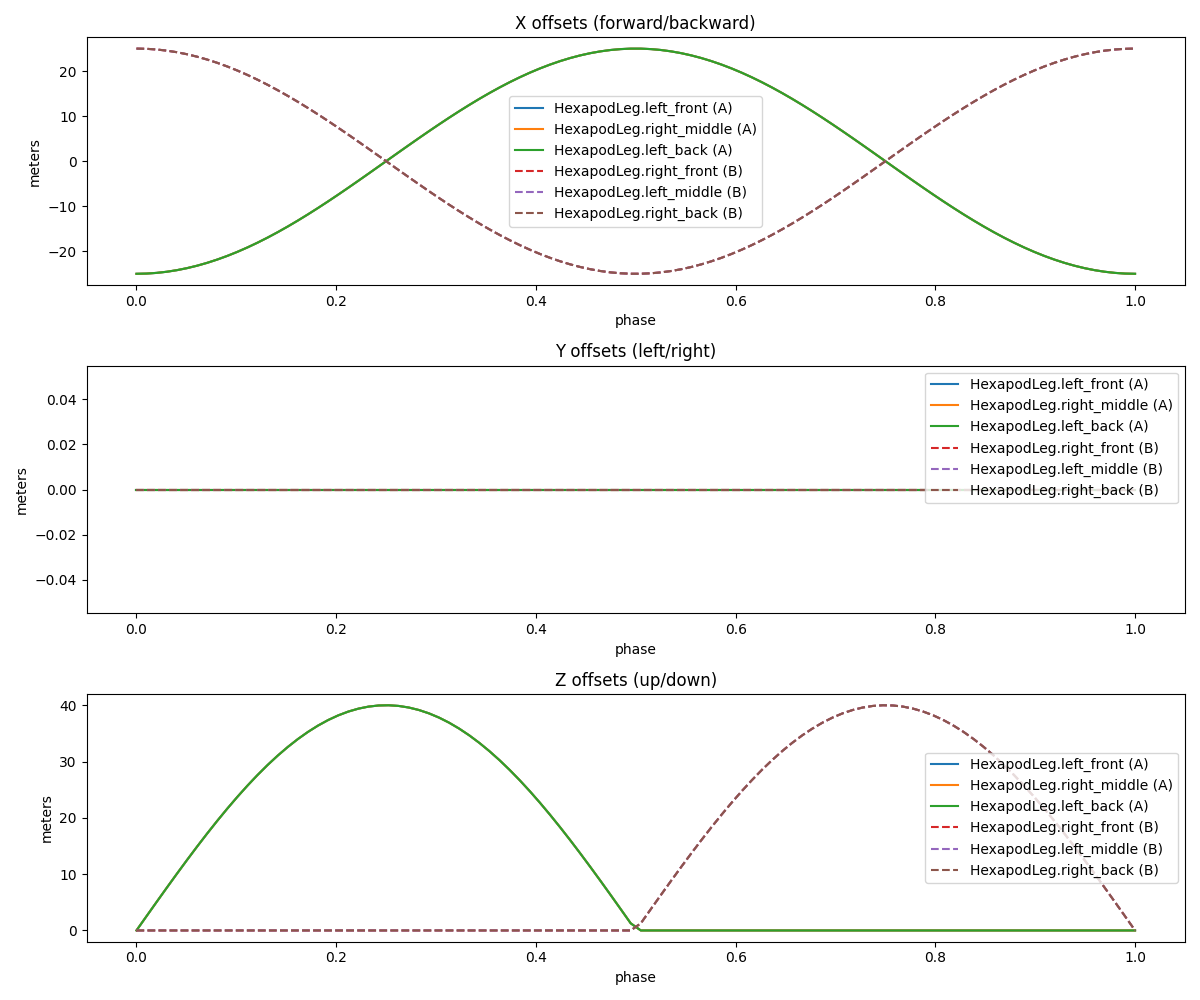

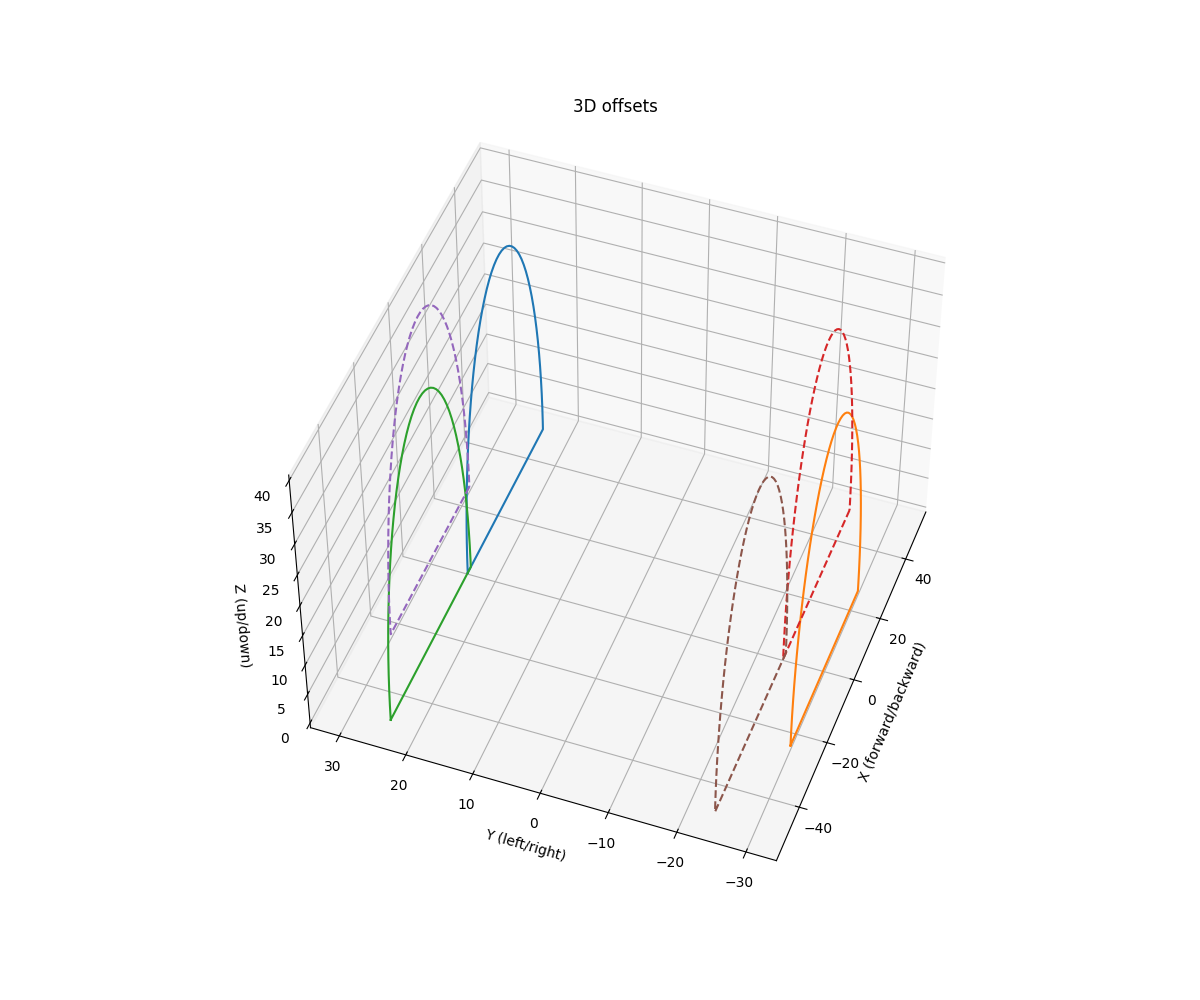

In [2]:
import numpy as np
from gait_generators import GaitGenerator
from point import Point3D
from models import HexapodLeg


class TripodGaitGenerator(GaitGenerator):
    def __init__(
        self,
        step_length=50,  # Length of each step in meters
        step_height=40,  # Height of leg lift in meters
    ):
        """
        Tripod gait generator for hexapod robot.

        Generates leg tip offsets in right-hand coordinate system (x-forward, y-left, z-up).

        Parameters:
        -----------
            step_length: Length of each step in meters
            step_height: Height of leg lift in meters

        """
        # Store parameters as member fields
        self.step_length = step_length
        self.step_height = step_height

        # Define leg groups for tripod gait
        self.tripod_a = [HexapodLeg.left_front, HexapodLeg.right_middle, HexapodLeg.left_back]
        self.tripod_b = [HexapodLeg.right_front, HexapodLeg.left_middle, HexapodLeg.right_back]
        super().__init__(all_legs=self.tripod_a + self.tripod_b)

    def get_offsets_at_phase(self, phase) -> dict[str, Point3D]:
        """
        Get offsets for all legs at a specific phase (0.0 to 1.0).

        Parameters:
        -----------
            phase: Float between 0.0 and 1.0 representing the gait cycle progress

        Returns:
        --------
            Dictionary of leg positions with their corresponding offsets

        """
        # Generate offsets for each leg group
        offsets = {}

        # Tripod A legs
        a_offset = self._calculate_leg_offset(phase)
        for leg in self.tripod_a:
            offsets[leg] = a_offset

        # Tripod B legs (half cycle offset)
        b_offset = self._calculate_leg_offset(phase + 0.5)
        for leg in self.tripod_b:
            offsets[leg] = b_offset

        return offsets

    def get_offsets_at_phase_for_leg(self, leg, phase) -> Point3D:
        """
        Get offsets for all legs at a specific phase (0.0 to 1.0).

        Parameters:
        -----------
            phase: Float between 0.0 and 1.0 representing the gait cycle progress

        Returns:
        --------
            Offset for the specified leg

        """
        # Tripod B legs (half cycle offset)
        if leg in self.tripod_b:
            phase += 0.5

        return self._calculate_leg_offset(phase)

    def _calculate_leg_offset(self, phase):
        """Calculate offset for a single leg at phase."""
        # Ensure phase is between 0 and 1
        phase = phase % 1.0

        # Convert phase to angle (0 to 2π)
        t = phase * 2 * np.pi

        # X movement: forward during swing phase, backward during stance phase
        x_offset = -self.step_length / 2 * np.cos(t)

        # Z movement: up during swing phase, down during stance phase
        z_offset = 0
        if np.sin(t) > 0:  # Only lift during swing phase
            z_offset = self.step_height * np.sin(t)

        # Y offset is always zero for straight walking
        y_offset = 0

        return Point3D([x_offset, y_offset, z_offset])

    def _legend_for_leg(self, leg) -> str:
        if leg in self.tripod_a:
            return f'{leg} (A)'
        return f'{leg} (B)'

    def _line_style_for_leg(self, leg) -> str:
        if leg in self.tripod_a:
            return '-'
        return '--'


# Example usage
generator = TripodGaitGenerator()

# Visualize the continuous gait
%matplotlib widget
generator.visualize_continuous(steps=100)

_ = generator.visualize_continuous_in_3d(steps=100)

interactive(children=(IntSlider(value=0, description='frame', max=60), Output()), _dom_classes=('widget-intera…

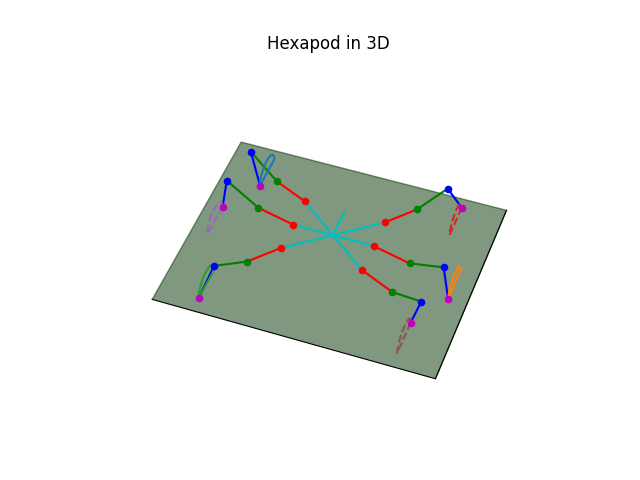

In [3]:
from matplotlib.animation import FuncAnimation
from ipywidgets import interact
from models import HexapodModel
from plotting import plot_hexapod, update_hexapod_plot, animate_plot_template


def animate_hexapod_gait(
    hexapod: HexapodModel,
    gaits_gen: GaitGenerator,
    interactive=False,
    skip=False,
    total_steps=60,
    interval=16,
    view_elev=47.0,
    view_azim=-160,
    repeat=1,
):
    def animate_impl():
        leg_centers = {leg.label: leg.tibia_end.copy() for leg in hexapod.legs}
        leg_tips = [leg.tibia_end.copy() for leg in hexapod.legs]

        def set_pose(step):
            step = step % total_steps  # handle repeats
            phase = step / total_steps  # interpolation phase
            for leg, leg_tip in zip(hexapod.legs, leg_tips):
                offsets = gaits_gen.get_offsets_at_phase_for_leg(leg.label, phase)
                leg.move_to(leg_tip + offsets)

        fig, ax, plot_data = plot_hexapod(hexapod)
        ax.view_init(elev=view_elev, azim=view_azim)

        generator.visualize_continuous_in_3d(steps=total_steps, ax=ax, plot_lines=None, leg_centers=leg_centers)

        def animate(frame=0):
            set_pose(frame)
            update_hexapod_plot(hexapod, plot_data)

        if interactive:
            return interact(animate, frame=(0, total_steps * repeat))
        return FuncAnimation(fig, animate, frames=total_steps * repeat, interval=interval)

    return animate_plot_template(animate_impl, interactive=interactive, skip=skip)


hexapod = HexapodModel()
hexapod.forward_kinematics(0, -25, 110)
generator = TripodGaitGenerator(step_length=120)

%matplotlib widget
anim = animate_hexapod_gait(hexapod, generator, interactive=True, skip=False)


This gives a nice forward locomotive gait. However some changes are needed to the generated gait. Right now it starts with legs on the ground, but with maxed out X offsets. To mitigate this we need to introduce a transition stage that will take legs from whatever position they are in to the starting position.

A good starting point for the transition is a 0.25 phase mark where all legs have zero offsets in X axis, however group A is lifted up. In order to start from all the legs on the ground we need to compress Z phase to quarter of the original cycle.

So here is the plan for transition stage: 
 1. It runs for 0.25 of the phase
 2. We start with X cycle at 0.25 
 3. We start Z cycle 0, but compress first 0.5 of it to 0.25. 
 4. At 0.5 both cycles sync up and cycle continues till 1.0
 5. Then we start the full cycle.

Transition out of gait is similar, but starts at 0 and ends at 0.25 or X and Z cycles is compressed to 0.25.

Below is the implementation of the transition. This kind of code works for the animation and is suitable for tripod gait, but with increase of gait complexity and with joystick style controls it would be impossible to implement it this way. We are going to explore a different approach later in this notebook.

interactive(children=(IntSlider(value=0, description='frame', max=180), Output()), _dom_classes=('widget-inter…

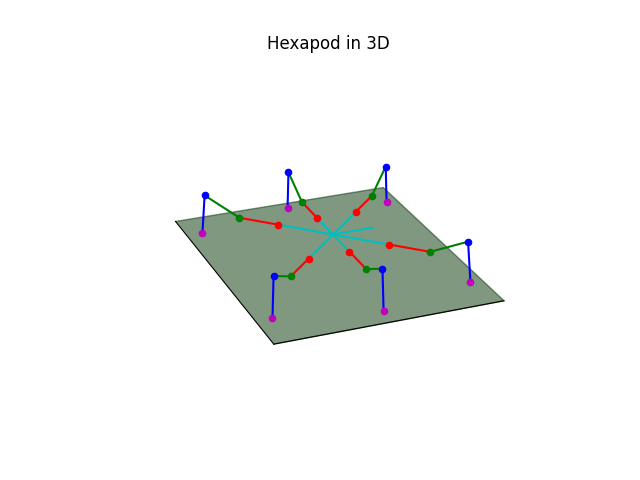

In [4]:

def animate_hexapod_gait_with_transitions(
    hexapod: HexapodModel,
    gaits_gen: GaitGenerator,
    interactive=False,
    skip=False,
    total_steps=60,
    interval=16,
    view_elev=7.0,
    view_azim=-112,
    repeat=2,
):
    transition_time_in = 0.75
    transition_steps_in = int(total_steps * transition_time_in)
    transition_steps_intro = int(total_steps * 0.25)
    transition_steps_rest = int(transition_steps_in - transition_steps_intro)

    phase_in_x_steps = np.concatenate((np.linspace(0.25, 0.5, transition_steps_intro), np.linspace(0.5, 1., transition_steps_rest)))
    phase_in_z_steps = np.concatenate((np.linspace(0.0, 0.5, transition_steps_intro), np.linspace(0.5, 1., transition_steps_rest)))

    transition_time_out = 0.25
    transition_steps_out = int(total_steps * transition_time_out)
    phase_out_x_steps = np.linspace(0.0, 0.25, transition_steps_out)
    phase_out_z_steps = np.linspace(0.0, 0.5, transition_steps_out)

    transition_steps_end = total_steps * repeat + transition_steps_in

    total_frames = total_steps * repeat + transition_steps_in + transition_steps_out

    def animate_impl():
        leg_tips = [leg.tibia_end.copy() for leg in hexapod.legs]


        def set_pose(step):
            if step < transition_steps_in:
                phase_x = phase_in_x_steps[step]
                phase_z = phase_in_z_steps[step]

                offsets = {}
                for leg in hexapod.legs:
                    off = gaits_gen.get_offsets_at_phase_for_leg(leg.label, phase_x)
                    offsets[leg.label] = Point3D([off.x, 0, 0])

                for leg in hexapod.legs:
                    off = gaits_gen.get_offsets_at_phase_for_leg(leg.label, phase_z)
                    offsets[leg.label] += Point3D([0, 0, off.z])

                for leg, leg_tip in zip(hexapod.legs, leg_tips):
                    leg.move_to(leg_tip + offsets[leg.label])
            elif step < transition_steps_end:
                step = step - transition_steps_in
                step = step % total_steps # handle repeats
                phase = step / total_steps # interpolation phase
                for leg, leg_tip in zip(hexapod.legs, leg_tips):
                    offsets = gaits_gen.get_offsets_at_phase_for_leg(leg.label, phase)
                    leg.move_to(leg_tip + offsets)

            else:
                end_step = (step - transition_steps_end)
                phase_x = phase_out_x_steps[end_step]
                phase_z = phase_out_z_steps[end_step]

                offsets = {}
                for leg in hexapod.legs:
                    off = gaits_gen.get_offsets_at_phase_for_leg(leg.label, phase_x)
                    offsets[leg.label] = Point3D([off.x, 0, 0])

                for leg in hexapod.legs:
                    off = gaits_gen.get_offsets_at_phase_for_leg(leg.label, phase_z)
                    offsets[leg.label] += Point3D([0, 0, off.z])

                for leg, leg_tip in zip(hexapod.legs, leg_tips):
                    leg.move_to(leg_tip + offsets[leg.label])

        fig, ax, plot_data = plot_hexapod(hexapod)
        ax.view_init(elev=view_elev, azim=view_azim)

        def animate(frame=0):
            set_pose(frame)
            update_hexapod_plot(hexapod, plot_data)

        if interactive:
            return interact(animate, frame=(0, total_frames))

        return FuncAnimation(fig, animate, frames=total_frames, interval=interval)

    return animate_plot_template(animate_impl, interactive=interactive, skip=skip)


hexapod = HexapodModel()
hexapod.forward_kinematics(0, -25, 110)
generator = TripodGaitGenerator(step_length=120)

%matplotlib widget
anim = animate_hexapod_gait_with_transitions(hexapod, generator, interactive=True, skip=False, view_elev=25)


This gives a nice forward locomotive gait. However it is forward only and there is no control over the direction of the movement. It is possible to move backwards by reversing the phase interpolation, but it would be nice to be able to control direction using the vector. This way this gait generator can be used with real robot and joystick control.

## Directional Gait Decorator

In order to add direction to the generated gait, we can create a decorator class that will take the generated offsets and apply a rotation to them. This way we can control the direction of the movement.

### TL;DR

We need a 2D rotation matrix that aligns the offsets (originally along the X-axis) with an arbitrary direction vector $[dx, dy]$. The rotation matrix that achieves this is:

\begin{bmatrix}
dx & -dy\\
dy & dx
\end{bmatrix}

### Why This Works

 - Original offsets are along the X-axis, meaning they can be represented as $[x, 0]$.
 - A A standard 2D rotation matrix for an angle $\theta$ is:


\begin{equation}
R=\begin{bmatrix}
\cos\theta & -\sin\theta\\
\sin\theta & \cos\theta
\end{bmatrix}
\end{equation}

 - The unit direction vector $[dx, dy]$ corresponds to the cosine and sine of some angle, where:

\begin{equation}
\begin{aligned}
dx = \cos\theta\\
dy = \sin\theta
\end{aligned}
\end{equation}

 - Substituting these into the rotation matrix gives us the desired transformation matrix.
 
\begin{equation}
R=\begin{bmatrix}
dx & -dy\\
dy & dx
\end{bmatrix}
\end{equation}

(<Axes3D: title={'center': '3D offsets\ndirection=Point3D(0.0000, 0.0000, 1.0000, UP/Stomp)'}, xlabel='X (forward/backward)', ylabel='Y (left/right)', zlabel='Z (up/down)'>,
 {<HexapodLeg.left_front: 1>: <mpl_toolkits.mplot3d.art3d.Line3D at 0x10efeac10>,
  <HexapodLeg.left_middle: 2>: <mpl_toolkits.mplot3d.art3d.Line3D at 0x10efead50>,
  <HexapodLeg.left_back: 3>: <mpl_toolkits.mplot3d.art3d.Line3D at 0x10efeae90>,
  <HexapodLeg.right_front: 4>: <mpl_toolkits.mplot3d.art3d.Line3D at 0x10efeafd0>,
  <HexapodLeg.right_middle: 5>: <mpl_toolkits.mplot3d.art3d.Line3D at 0x10efeb110>,
  <HexapodLeg.right_back: 6>: <mpl_toolkits.mplot3d.art3d.Line3D at 0x10efeb250>})

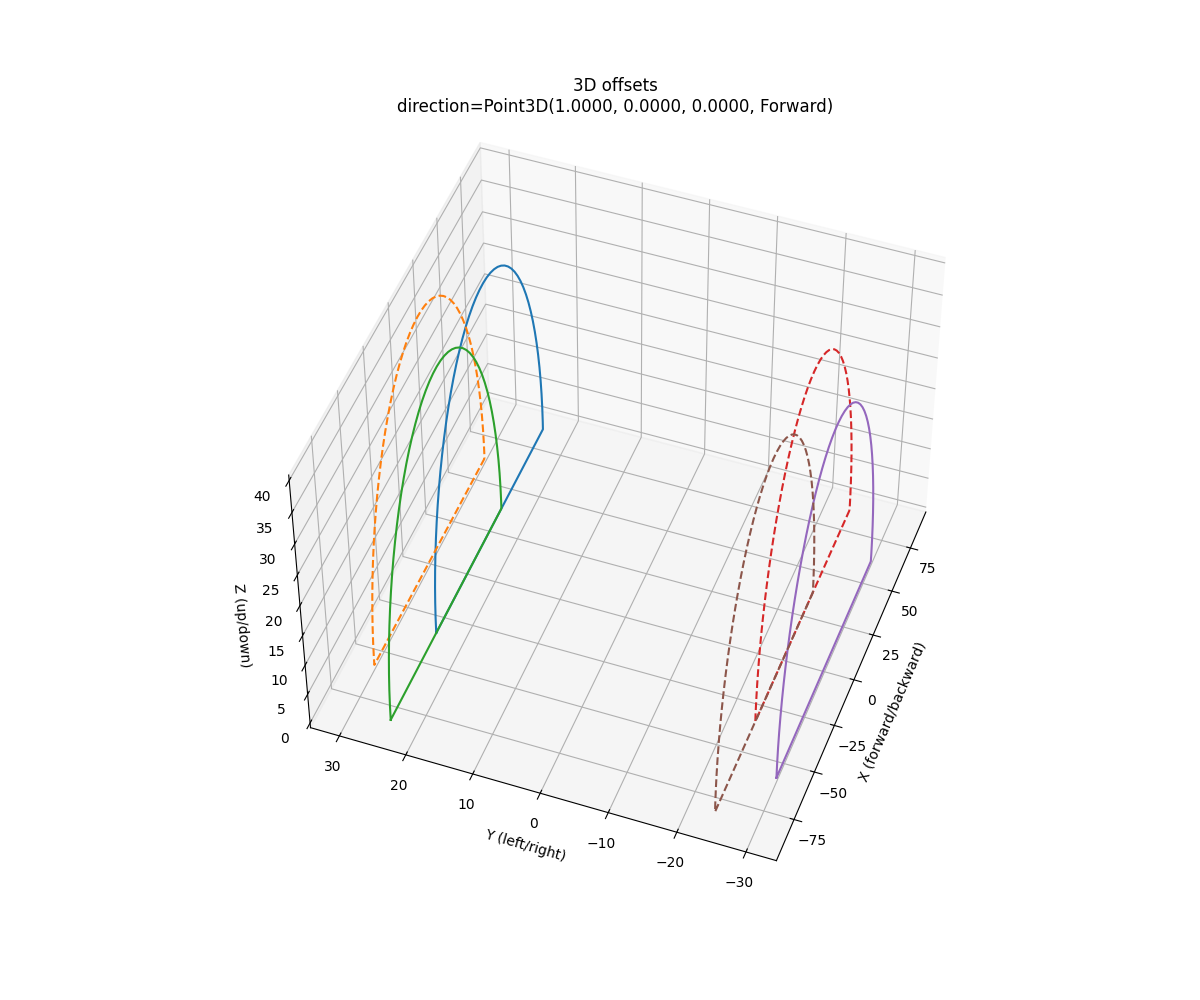

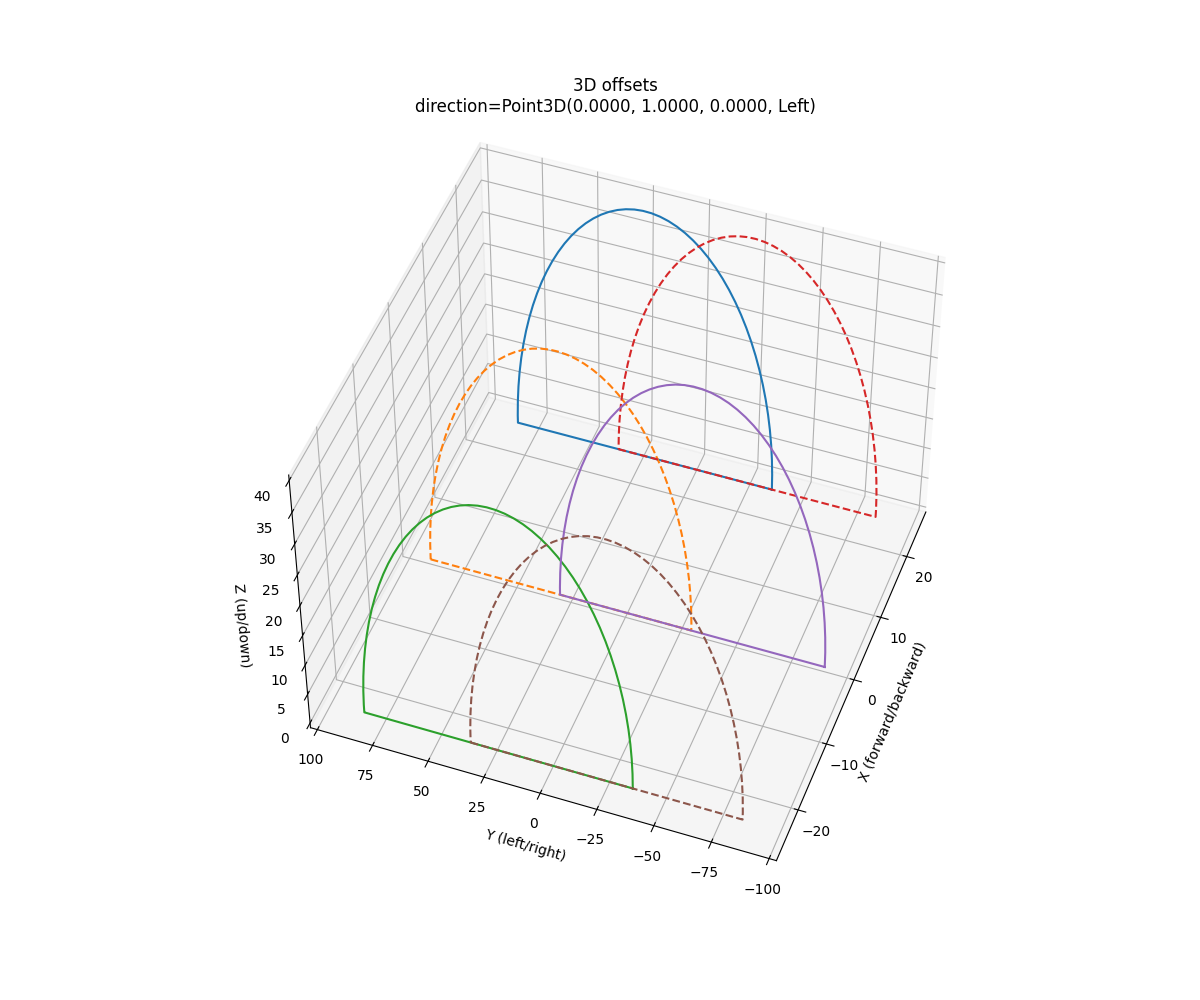

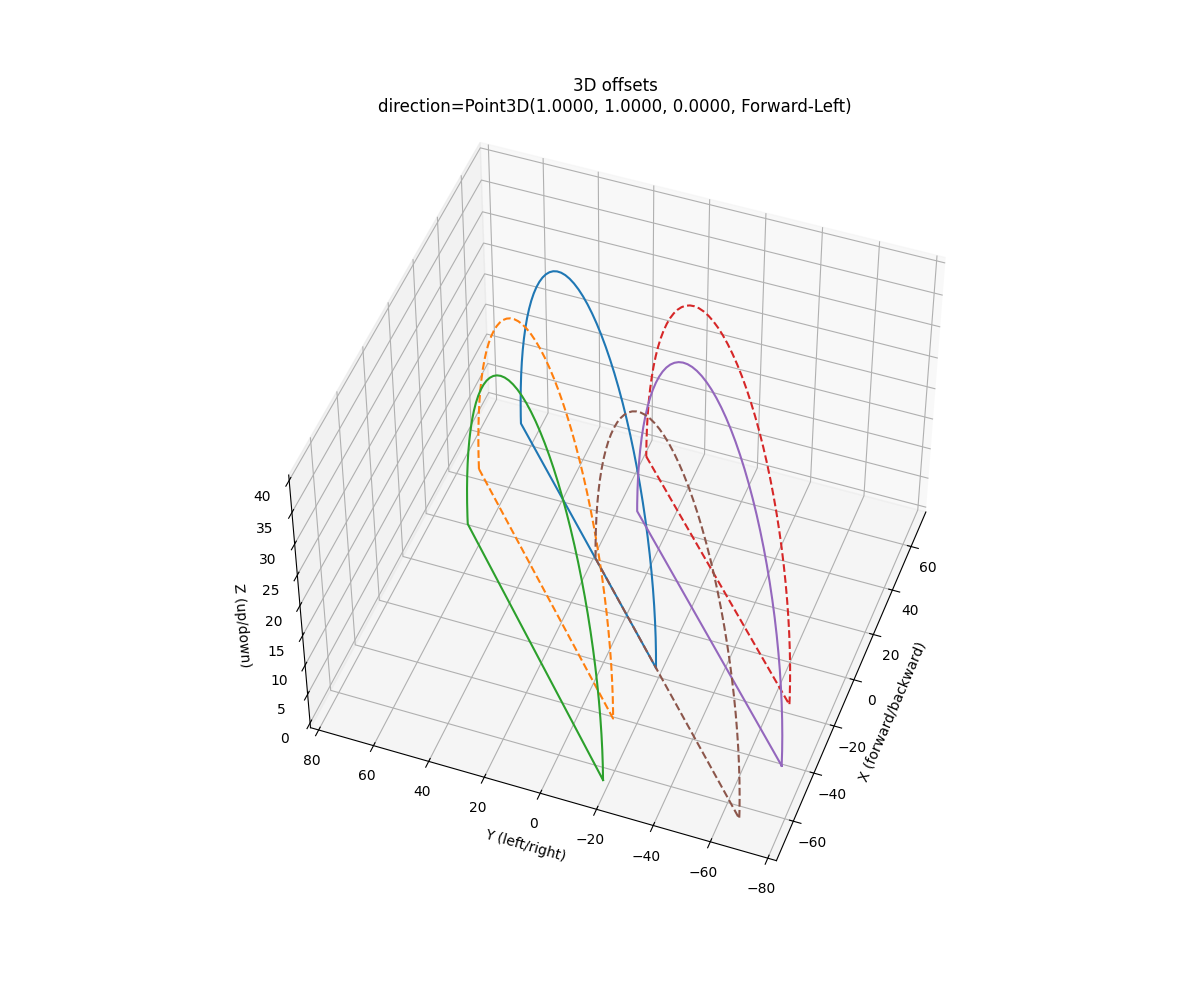

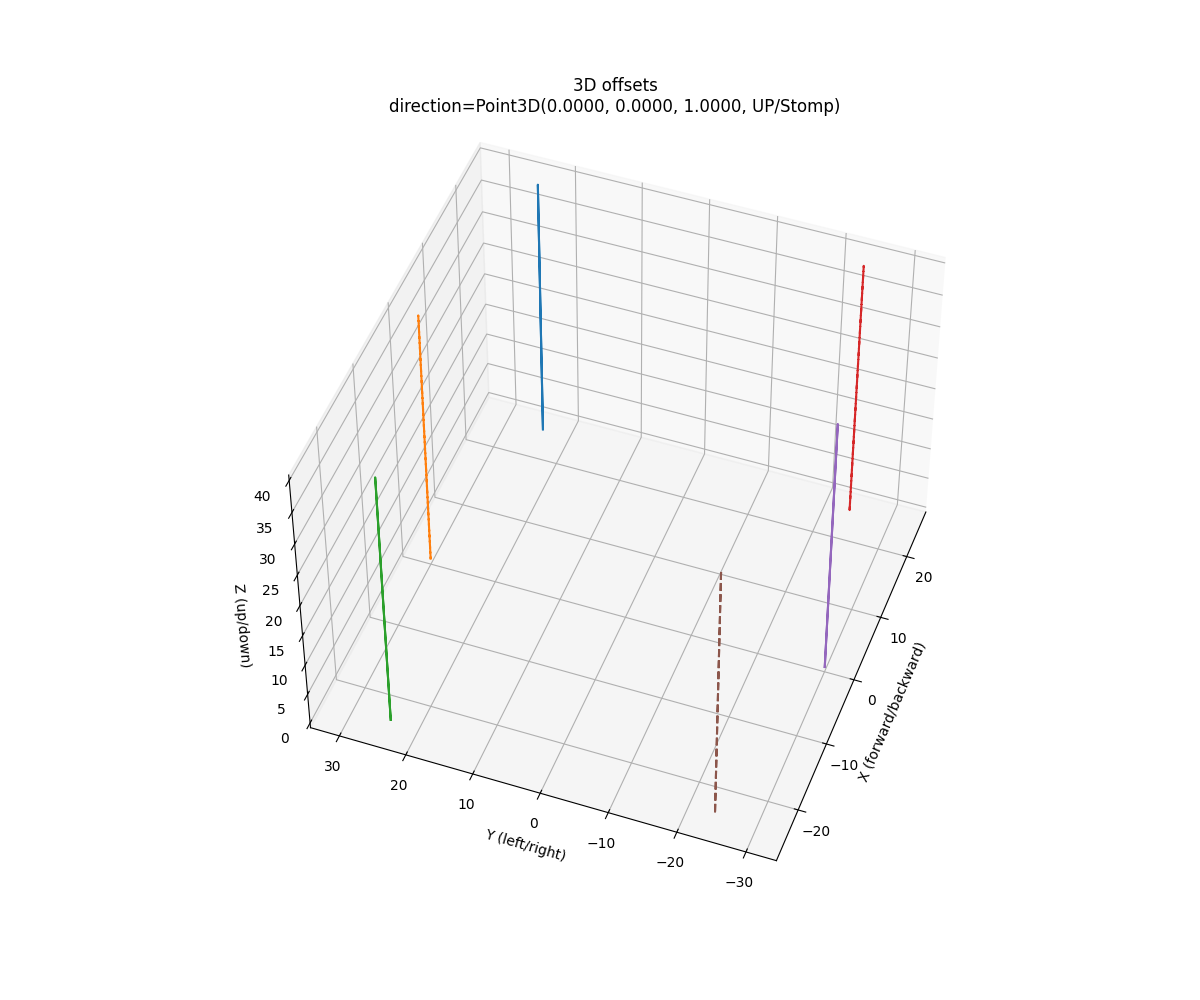

In [5]:
from transforms import Transform

class DirectionalGaitGenerator(GaitGenerator):
    """Gait generator decorator to allow steering in any direction."""

    def __init__(self, decorated: GaitGenerator):
        super().__init__()
        self.decorated = decorated

    def get_offsets_at_phase(self, phase, direction=Point3D([1, 0, 0])) -> dict[str, Point3D]:
        tf = self.__make_transform(direction)
        offsets = self.decorated.get_offsets_at_phase(phase)
        return {leg: tf.apply_point(offsets[leg]) for leg in offsets}

    def get_offsets_at_phase_for_leg(self, leg, phase, direction=Point3D([1, 0, 0])) -> Point3D:
        tf = self.__make_transform(direction)
        offsets = self.decorated.get_offsets_at_phase_for_leg(leg, phase)
        return tf.apply_point(offsets)

    @staticmethod
    def __make_transform(direction):
        # Normalize direction vector
        norm_direction = direction.normalized().numpy()

        # Create rotation matrix to align direction with x-axis
        # Ignore z-component as robot can't walk up. This also allows to generate steering in place
        direction_transform = Transform.from_rotmatrix([
            [norm_direction[0], -norm_direction[1], 0],
            [norm_direction[1], norm_direction[0], 0],
            [0, 0, 1]
        ])
        return direction_transform

    def _legend_for_leg(self, leg) -> str:
        return self.decorated._legend_for_leg(leg)

    def _line_style_for_leg(self, leg) -> str:
        return self.decorated._line_style_for_leg(leg)


# Example usage
directional_tripod_gen = DirectionalGaitGenerator(TripodGaitGenerator(step_length=120))

directional_tripod_gen.visualize_continuous_in_3d(direction=Point3D([1, 0, 0], "Forward"))
directional_tripod_gen.visualize_continuous_in_3d(direction=Point3D([0, 1, 0], "Left"))
directional_tripod_gen.visualize_continuous_in_3d(direction=Point3D([1, 1, 0], "Forward-Left"))

# stomp in place
directional_tripod_gen.visualize_continuous_in_3d(direction=Point3D([0, 0, 1], "UP/Stomp"))


Adding a direction vector did the trick, at least charts look good. Let's see it on the hexapod.

interactive(children=(IntSlider(value=0, description='frame', max=60), IntSlider(value=0, description='directi…

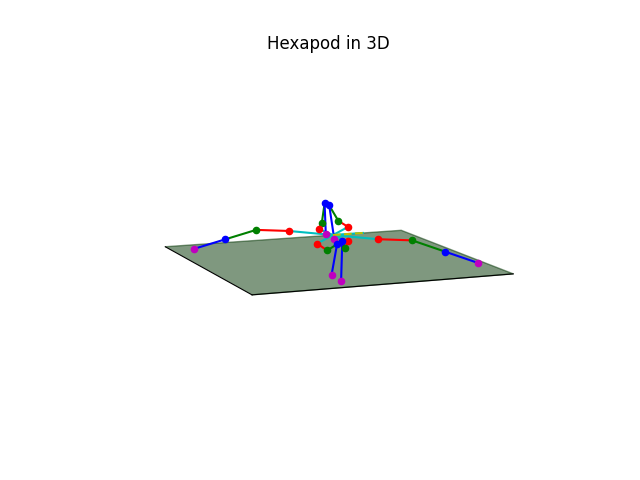

In [6]:
from functools import partial


def animate_hexapod_gait_with_direction(
    hexapod: HexapodModel,
    gaits_gen: GaitGenerator,
    interactive=False,
    animate_trajectory=False,
    skip=False,
    total_steps=60,
    interval=16,
    view_elev=10.0,
    view_azim=-112,
    repeat=1,
    gait_lines=None,
    direction_degrees=0,
    animate_direction_degrees=False,
    direction_vector_length=100,
    trajectory_animation_start=0,
    trajectory_animation_end=1,
):
    def animate_impl():
        leg_tips = [leg.tibia_end.copy() for leg in hexapod.legs]
        leg_centers = {leg.label: leg.tibia_end.copy() for leg in hexapod.legs}

        def set_pose(step, direction):
            step = step % total_steps  # handle repeats
            phase = step / total_steps  # interpolation phase
            for leg, leg_tip in zip(hexapod.legs, leg_tips):
                offsets = gaits_gen.get_offsets_at_phase_for_leg(
                    leg.label, phase, direction=direction
                )
                leg.move_to(leg_tip + offsets)

        fig, ax, plot_data = plot_hexapod(hexapod)
        ax.view_init(elev=view_elev, azim=view_azim)
        dir_plot = ax.plot([0, direction_vector_length], [0, 0], [0, 0], 'y--')

        nonlocal gait_lines
        nonlocal trajectory_animation_end
        if animate_trajectory:
            trajectory_animation_end = 0
        _, gait_lines = gaits_gen.visualize_continuous_in_3d(
            steps=total_steps,
            ax=ax,
            phase_start=trajectory_animation_start,
            phase_end=trajectory_animation_end,
            plot_lines=None,
            leg_centers=leg_centers,
        )

        def animate(frame=0, direction_degrees=direction_degrees):
            if animate_direction_degrees:
                direction_degrees = (frame / (total_steps * repeat)) * 360
            direction = Transform.from_rotvec([0, 0, direction_degrees], degrees=True).apply_point(
                Point3D([1, 0, 0])
            )
            set_pose(frame, direction)
            update_hexapod_plot(hexapod, plot_data)
            dir_line = direction * direction_vector_length
            dir_plot[0].set_data_3d([0, dir_line.x], [0, dir_line.y], [0, dir_line.z])

            nonlocal gait_lines
            nonlocal trajectory_animation_end
            if animate_trajectory:
              step = frame % total_steps  # handle repeats
              trajectory_animation_end = step / total_steps  # interpolation phase

            _, gait_lines = gaits_gen.visualize_continuous_in_3d(
                steps=total_steps,
                ax=ax,
                phase_start=trajectory_animation_start,
                phase_end=trajectory_animation_end,
                plot_lines=gait_lines,
                leg_centers=leg_centers,
                direction=direction,
            )
            if interactive:
                fig.canvas.draw_idle()

        if interactive:
            return interact(
                animate, direction_degrees=(-180, 180, 1), frame=(0, total_steps * repeat)
            )

        return FuncAnimation(
            fig,
            animate,
            frames=total_steps * repeat,
            interval=interval,
        )

    return animate_plot_template(animate_impl, interactive=interactive, skip=skip)


hexapod = HexapodModel()
hexapod.forward_kinematics(0, -25, 110)

%matplotlib widget
anim = animate_hexapod_gait_with_direction(
    hexapod, directional_tripod_gen, skip=False, animate_trajectory=True, animate_direction_degrees=False, repeat=1
)
anim = animate_hexapod_gait_with_direction(
    hexapod, directional_tripod_gen, interactive=True, skip=False, animate_trajectory=True
)


That is a fully functional tripod gait generator with full steering capabilities. Time to move to the ripple gait generator.

## Ripple gait

Ripple gait is a bit more complex as it moves one leg at a time, but it looks more natural and provides more stable movement.

This RippleGaitGenerator implements a classic ripple gait where:

 1. Legs move in a 6-phase sequence
 2. Each leg is 1/6 cycle out of phase with the next leg
 3. The stance phase (on ground) is 2/3 of the cycle
 4. The swing phase (in air) is 1/3 of the cycle
 5. During stance, the leg moves backward linearly
 6. During swing, the leg lifts in a parabolic trajectory while moving forward

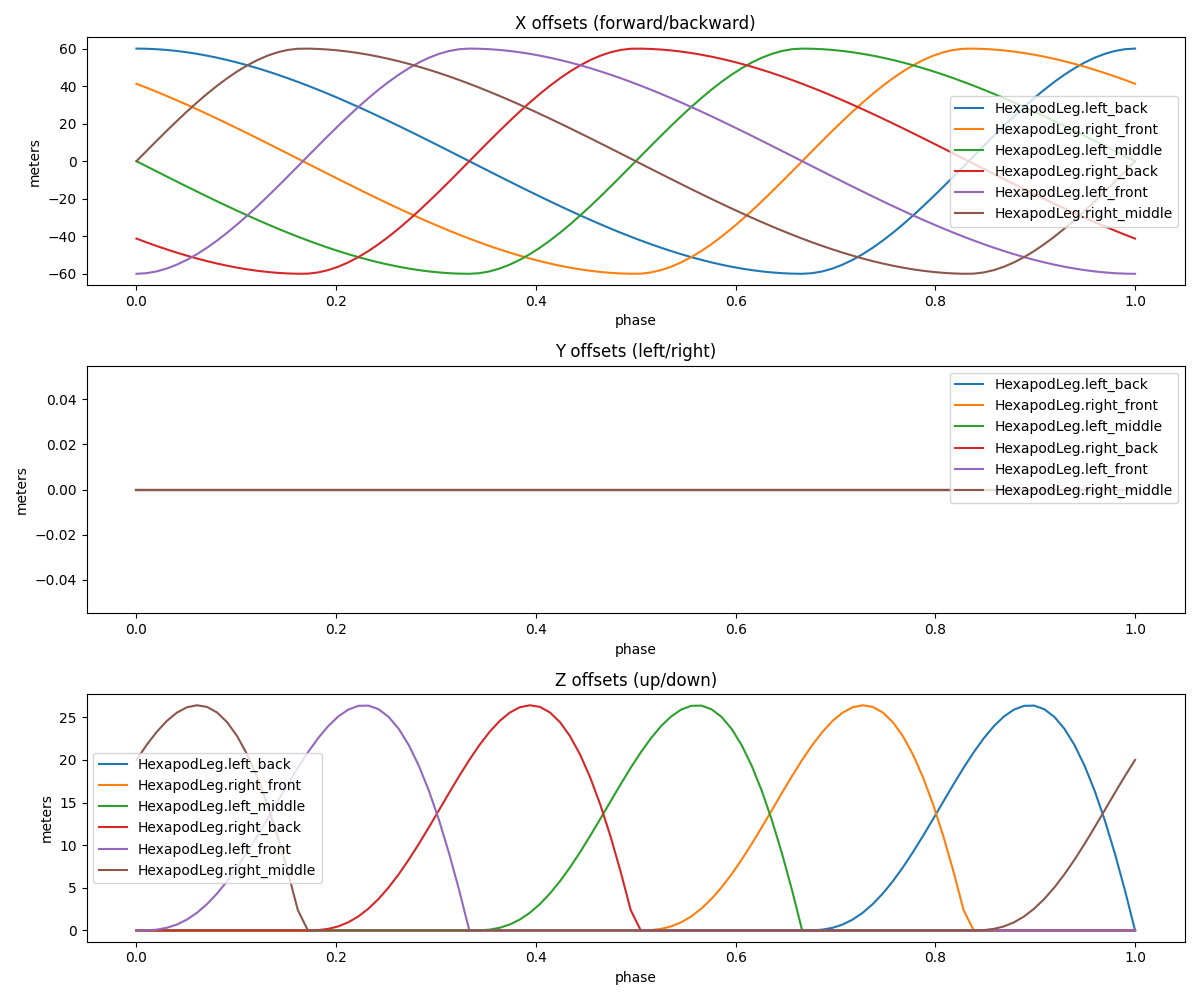

(<Axes3D: title={'center': '3D offsets'}, xlabel='X (forward/backward)', ylabel='Y (left/right)', zlabel='Z (up/down)'>,
 {<HexapodLeg.left_back: 3>: <mpl_toolkits.mplot3d.art3d.Line3D at 0x119688190>,
  <HexapodLeg.right_front: 4>: <mpl_toolkits.mplot3d.art3d.Line3D at 0x1196882d0>,
  <HexapodLeg.left_middle: 2>: <mpl_toolkits.mplot3d.art3d.Line3D at 0x119688410>,
  <HexapodLeg.right_back: 6>: <mpl_toolkits.mplot3d.art3d.Line3D at 0x119688550>,
  <HexapodLeg.left_front: 1>: <mpl_toolkits.mplot3d.art3d.Line3D at 0x119688690>,
  <HexapodLeg.right_middle: 5>: <mpl_toolkits.mplot3d.art3d.Line3D at 0x1196887d0>})

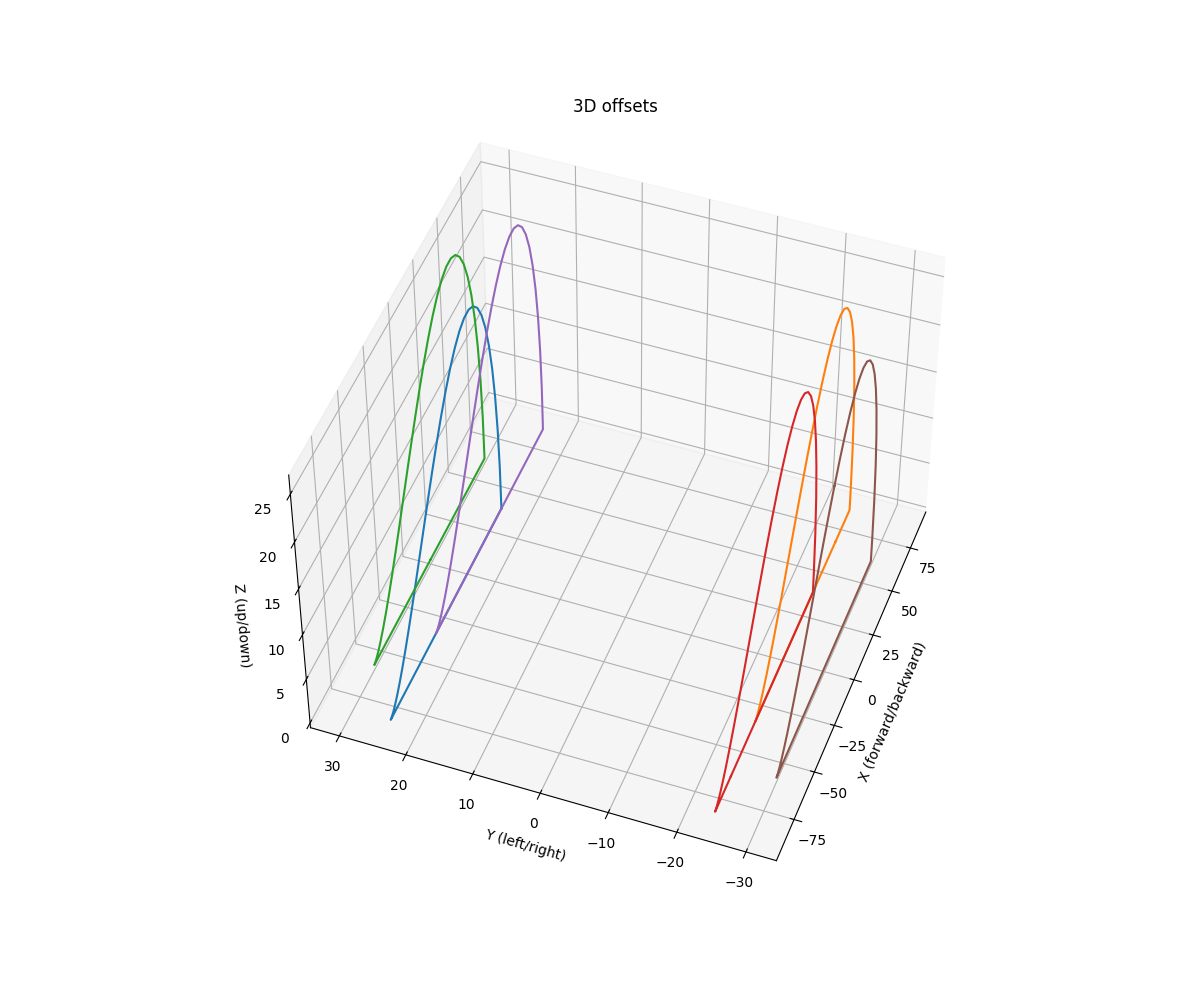

In [7]:
class RippleGaitGenerator(GaitGenerator):
    def __init__(
        self,
        step_length=50,  # Length of each step in meters
        step_height=40,  # Height of leg lift in meters
    ):
        """
        Ripple gait generator for hexapod robot.

        Generates leg tip offsets in right-hand coordinate system (x-forward, y-left, z-up).

        Parameters:
        -----------
            step_length: Length of each step in meters
            step_height: Height of leg lift in meters
        """
        # Store parameters as member fields
        self.step_length = step_length
        self.step_height = step_height

        # Define leg groups for ripple gait (6-phase)
        self.leg_sequence = [
            HexapodLeg.left_back,
            HexapodLeg.right_front,
            HexapodLeg.left_middle,
            HexapodLeg.right_back,
            HexapodLeg.left_front,
            HexapodLeg.right_middle,
        ]
        super().__init__(all_legs=self.leg_sequence)

    def get_offsets_at_phase(self, phase) -> dict[str, Point3D]:
        """
        Get offsets for all legs at a specific phase (0.0 to 1.0).

        Parameters:
        -----------
            phase: Float between 0.0 and 1.0 representing the gait cycle progress

        Returns:
        --------
            Dictionary of leg positions with their corresponding offsets
        """
        offsets = {}
        for leg in self.all_legs:
            offsets[leg] = self.get_offsets_at_phase_for_leg(leg, phase)
        return offsets

    def get_offsets_at_phase_for_leg(self, leg, phase) -> Point3D:
        """
        Get offset for a specific leg at a specific phase (0.0 to 1.0).

        Parameters:
        -----------
            leg: Leg identifier string
            phase: Float between 0.0 and 1.0 representing the gait cycle progress

        Returns:
        --------
            Offset for the specified leg
        """
        # Get leg's position in sequence (0-5)
        leg_index = self.leg_sequence.index(leg)

        # Adjust phase for this leg (each leg is 1/6 cycle offset from previous)
        leg_phase = (phase + leg_index / 6) % 1.0

        return self._calculate_leg_offset(leg_phase)

    def _calculate_leg_offset(self, phase):
        """
        Calculate the offset for a leg at a specific phase using polynomial functions for smoother motion with proper ease-in/ease-out.

        Parameters:
        -----------
            phase: Float between 0.0 and 1.0

        Returns:
        --------
            Point3D with x, y, z offsets

        """
        # Stance phase (on ground) is 2/3 of the cycle
        stance_duration = 2 / 3

        # Swing phase (in air) is 1/3 of the cycle
        swing_duration = 1 / 3

        if phase < stance_duration:
            # Stance phase - leg on ground moving backward
            # Normalize phase to 0-1 range for stance
            stance_phase = phase / stance_duration

            # Cubic polynomial for smoother ease-in/ease-out during stance
            # f(t) = at³ + bt² + ct + d where f(0)=0.5, f(1)=-0.5, f'(0)=0, f'(1)=0
            t = stance_phase
            x_offset = self.step_length * (0.5 - (3 * t**2 - 2 * t**3))
            z_offset = 0  # On ground

        else:
            # Swing phase - leg in air moving forward
            # Normalize phase to 0-1 range for swing
            swing_phase = (phase - stance_duration) / swing_duration

            # Cubic polynomial for smoother ease-in/ease-out during swing
            # f(t) = at³ + bt² + ct + d where f(0)=-0.5, f(1)=0.5, f'(0)=0, f'(1)=0
            t = swing_phase
            x_offset = self.step_length * (-0.5 + (3 * t**2 - 2 * t**3))

            # Modified parabolic trajectory with ease-in and ease-out
            # Blend parabolic curve with ease functions at the endpoints

            # Base parabolic function (4t(1-t))
            parabola = 4 * t * (1 - t)
            # Ease-in/ease-out factor (3t² - 2t³) that's 0 at t=0 and 1 at t=1 with smooth derivatives
            ease = 3 * t * t - 2 * t * t * t
            # Scale the parabola by the ease factor to smooth the endpoints
            z_offset = self.step_height * parabola * ease

        return Point3D([x_offset, 0, z_offset])

    def _calculate_leg_offset_linear_x(self, phase):
        """
        Calculate the offset for a leg at a specific phase.

        Parameters:
        -----------
            phase: Float between 0.0 and 1.0

        Returns:
        --------
            Point3D with x, y, z offsets

        """
        # Stance phase (on ground) is 2/3 of the cycle
        stance_duration = 2 / 3

        # Swing phase (in air) is 1/3 of the cycle
        swing_duration = 1 / 3

        if phase < stance_duration:
            # Stance phase - leg on ground moving backward
            # Normalize phase to 0-1 range for stance
            stance_phase = phase / stance_duration

            # Linear movement from front to back
            x_offset = self.step_length * (0.5 - stance_phase)
            z_offset = 0  # On ground

        else:
            # Swing phase - leg in air moving forward
            # Normalize phase to 0-1 range for swing
            swing_phase = (phase - stance_duration) / swing_duration

            # Move from back to front
            x_offset = self.step_length * (-0.5 + swing_phase)

            # Parabolic trajectory for lifting leg
            z_offset = self.step_height * 4 * swing_phase * (1 - swing_phase)

        return Point3D([x_offset, 0, z_offset])


ripple_gen = RippleGaitGenerator(step_length=120)
ripple_gen.visualize_continuous()
ripple_gen.visualize_continuous_in_3d()

interactive(children=(IntSlider(value=0, description='frame', max=60), IntSlider(value=0, description='directi…

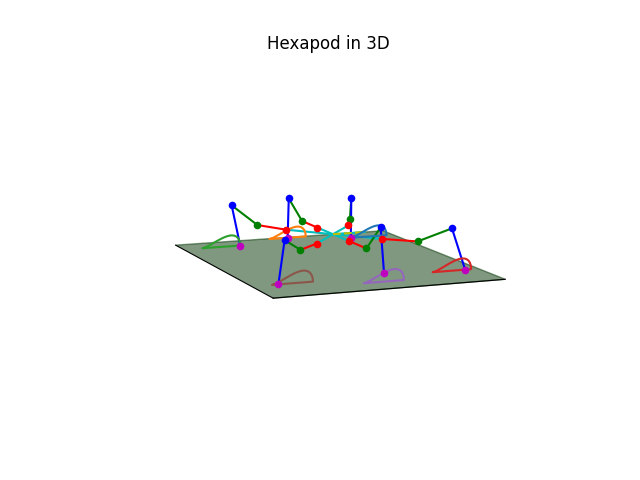

In [8]:
hexapod = HexapodModel()
hexapod.forward_kinematics(0, -25, 110)

directional_ripple_gen = DirectionalGaitGenerator(ripple_gen)

%matplotlib widget
anim = animate_hexapod_gait_with_direction(hexapod, directional_ripple_gen, interactive=True, skip=False)

## Wave Gait

The WaveGaitGenerator implements a wave gait with these key characteristics:

 1. Only one leg is lifted at a time (maximum stability)
 2. Legs move in a wave-like sequence from back to front
 3. Each leg is 1/6 cycle out of phase with the next leg
 4. The stance phase (on ground) is 5/6 of the cycle
 5. The swing phase (in air) is only 1/6 of the cycle
 6. During stance, the leg moves backward linearly
 7. During swing, the leg lifts in a parabolic trajectory while moving forward


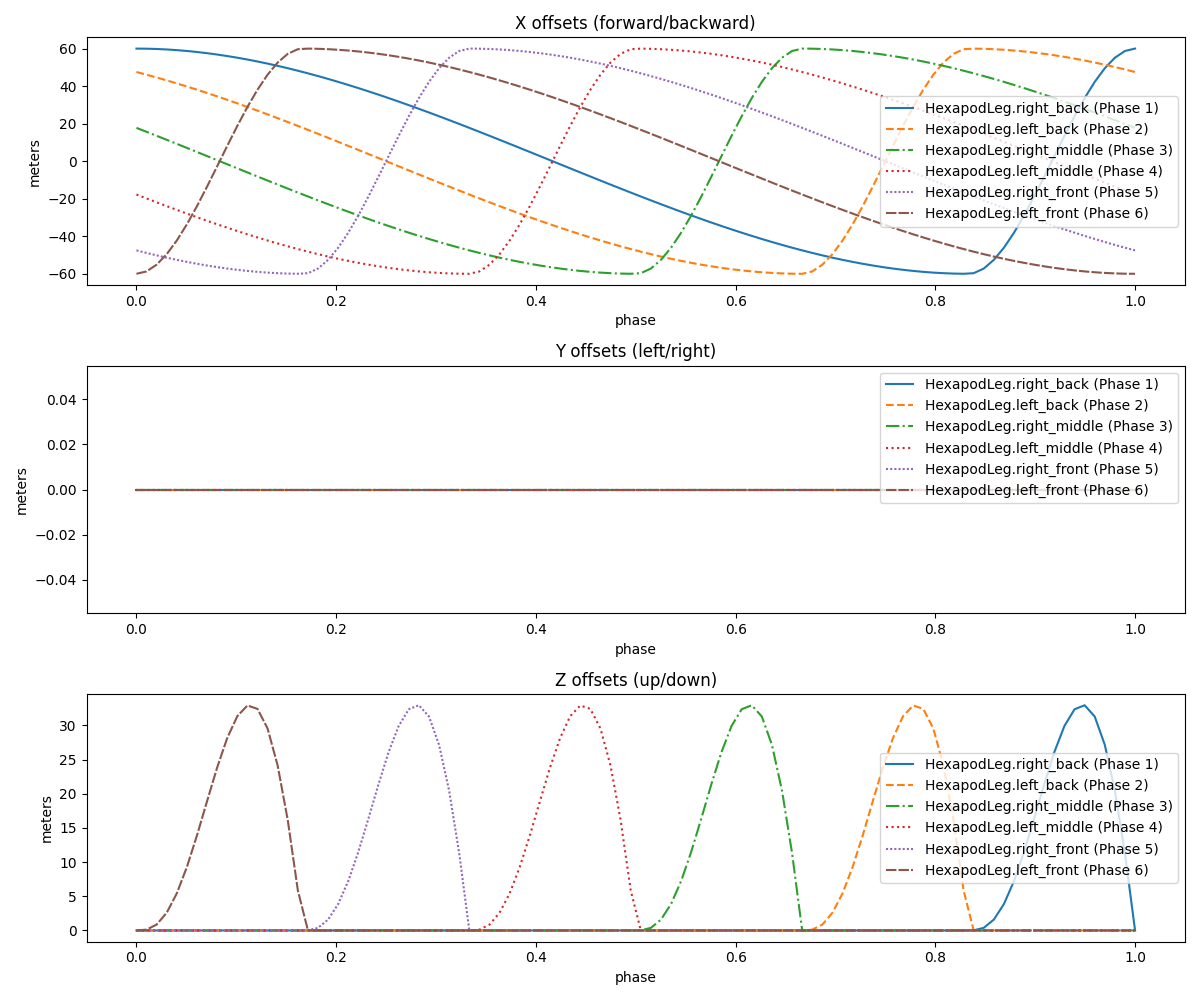

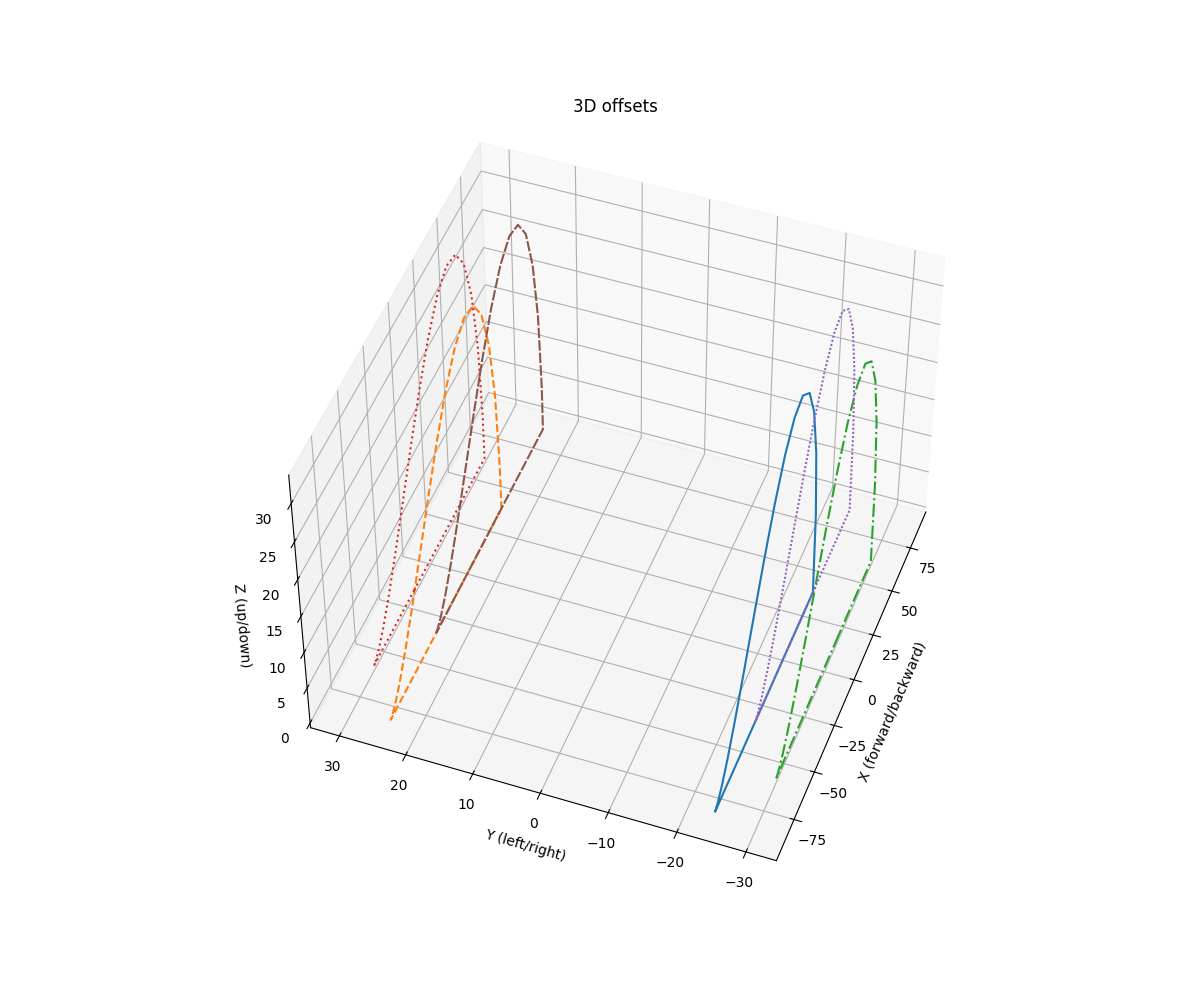

In [9]:
class WaveGaitGenerator(GaitGenerator):
    def __init__(
        self,
        step_length=50,  # Length of each step in meters
        step_height=40,  # Height of leg lift in meters
    ):
        """
        Wave gait generator for hexapod robot.

        In wave gait, only one leg is lifted at a time, providing maximum stability.
        Legs move in a wave-like sequence from back to front.

        Generates leg tip offsets in right-hand coordinate system (x-forward, y-left, z-up).

        Parameters:
        -----------
            step_length: Length of each step in meters
            step_height: Height of leg lift in meters
        """
        # Store parameters as member fields
        self.step_length = step_length
        self.step_height = step_height

        # Define leg sequence for wave gait (back to front)
        self.leg_sequence = [
            HexapodLeg.right_back,
            HexapodLeg.left_back,
            HexapodLeg.right_middle,
            HexapodLeg.left_middle,
            HexapodLeg.right_front,
            HexapodLeg.left_front,
        ]
        super().__init__(all_legs=self.leg_sequence)

    def get_offsets_at_phase(self, phase) -> dict[str, Point3D]:
        """
        Get offsets for all legs at a specific phase (0.0 to 1.0).

        Parameters:
        -----------
            phase: Float between 0.0 and 1.0 representing the gait cycle progress

        Returns:
        --------
            Dictionary of leg positions with their corresponding offsets

        """
        offsets = {}
        for leg in self.all_legs:
            offsets[leg] = self.get_offsets_at_phase_for_leg(leg, phase)
        return offsets

    def get_offsets_at_phase_for_leg(self, leg, phase) -> Point3D:
        """
        Get offset for a specific leg at a specific phase (0.0 to 1.0).

        Parameters:
        -----------
            leg: Leg identifier string
            phase: Float between 0.0 and 1.0 representing the gait cycle progress

        Returns:
        --------
            Offset for the specified leg

        """
        # Get leg's position in sequence (0-5)
        leg_index = self.leg_sequence.index(leg)

        # Adjust phase for this leg (each leg is 1/6 cycle offset from previous)
        leg_phase = (phase + leg_index / 6) % 1.0

        return self._calculate_leg_offset_poly_x(leg_phase)

    def _calculate_leg_offset_poly_x(self, phase):
        """
        Calculate the offset for a leg at a specific phase using polynomial functions for smoother motion with proper ease-in/ease-out.

        Parameters:
        -----------
            phase: Float between 0.0 and 1.0

        Returns:
        --------
            Point3D with x, y, z offsets

        """
        # In wave gait, stance phase is 5/6 of the cycle (only 1/6 for swing)
        stance_duration = 5 / 6
        swing_duration = 1 / 6

        if phase < stance_duration:
            # Stance phase - leg on ground moving backward
            # Normalize phase to 0-1 range for stance
            stance_phase = phase / stance_duration

            # Cubic polynomial for smoother ease-in/ease-out during stance
            # f(t) = at³ + bt² + ct + d where f(0)=0.5, f(1)=-0.5, f'(0)=0, f'(1)=0
            t = stance_phase
            x_offset = self.step_length * (0.5 - (3 * t**2 - 2 * t**3))
            z_offset = 0  # On ground

        else:
            # Swing phase - leg in air moving forward
            # Normalize phase to 0-1 range for swing
            swing_phase = (phase - stance_duration) / swing_duration

            # Cubic polynomial for smoother ease-in/ease-out during swing
            # f(t) = at³ + bt² + ct + d where f(0)=-0.5, f(1)=0.5, f'(0)=0, f'(1)=0
            t = swing_phase
            x_offset = self.step_length * (-0.5 + (3 * t**2 - 2 * t**3))

            # Modified parabolic trajectory with ease-in and ease-out
            # Blend parabolic curve with ease functions at the endpoints

            # Base parabolic function (4t(1-t))
            parabola = 4 * t * (1 - t)
            # Ease-in/ease-out factor (3t² - 2t³) that's 0 at t=0 and 1 at t=1 with smooth derivatives
            ease = 3 * t * t - 2 * t * t * t
            # Scale the parabola by the ease factor to smooth the endpoints
            z_offset = self.step_height * parabola * ease

        return Point3D([x_offset, 0, z_offset])

    def _calculate_leg_offset_linear_x(self, phase):
        """
        Calculate the offset for a leg at a specific phase.

        Parameters:
        -----------
            phase: Float between 0.0 and 1.0

        Returns:
        --------
            Point3D with x, y, z offsets

        """
        # In wave gait, stance phase is 5/6 of the cycle (only 1/6 for swing)
        stance_duration = 5 / 6
        swing_duration = 1 / 6

        if phase < stance_duration:
            # Stance phase - leg on ground moving backward
            # Normalize phase to 0-1 range for stance
            stance_phase = phase / stance_duration

            # Linear movement from front to back
            x_offset = self.step_length * (0.5 - stance_phase)
            z_offset = 0  # On ground

        else:
            # Swing phase - leg in air moving forward
            # Normalize phase to 0-1 range for swing
            swing_phase = (phase - stance_duration) / swing_duration

            # Move from back to front
            x_offset = self.step_length * (-0.5 + swing_phase)

            # Parabolic trajectory for lifting leg
            z_offset = self.step_height * 4 * swing_phase * (1 - swing_phase)

        return Point3D([x_offset, 0, z_offset])

    def _legend_for_leg(self, leg) -> str:
        leg_index = self.leg_sequence.index(leg)
        return f'{leg} (Phase {leg_index + 1})'

    def _line_style_for_leg(self, leg) -> str:
        leg_index = self.leg_sequence.index(leg)
        style = {
            0: '-',
            1: '--',
            2: '-.',
            3: ':',
            4: (0, (1, 1)),
            5: (0, (5, 1)),
        }
        return style[leg_index]


wave_generator = WaveGaitGenerator(step_length=120, step_height=50)
wave_generator.visualize_continuous(steps=100)
_ = wave_generator.visualize_continuous_in_3d(steps=100)


interactive(children=(IntSlider(value=0, description='frame', max=60), IntSlider(value=0, description='directi…

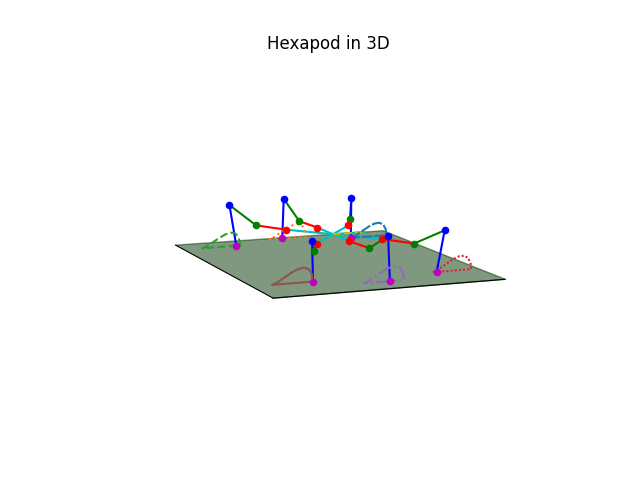

In [10]:
hexapod = HexapodModel()
hexapod.forward_kinematics(0, -25, 110)

directional_wave_gen = DirectionalGaitGenerator(wave_generator)
anim = animate_hexapod_gait_with_direction(
    hexapod,
    directional_wave_gen,
    interactive=False,
    skip=True, ######
    animate_trajectory=True,
    animate_direction_degrees=False,
    repeat=1,
)
inter = animate_hexapod_gait_with_direction(
    hexapod, directional_wave_gen, interactive=True, skip=False
)


## Summary and steps forward (pun intended)

With the current approach we have achieved decent results and it helped us to get a basic understanding of gaits generation, however it has a serious limitations:
 1. It is not possible to transition between gaits as they are implemented as separate classes
 2. There is no transition in and out of the gait from standing position.
 3. Different gaits have different trajectories, however the only thing that has to change is the order in which legs are lifted.
 4. Phase logic is mixed with trajectory logic.

Lets rework the code to address all these issues and have production ready solution we will use in the next notebook that will be taking all we have learned so far to real ROS implementation controlling a simulated robot in Gazebo.

Our new approach should satisfy the following requirements:
 1. Allow defining a gait trajectory.
 2. Allow defining a gait sequence.
 3. Allow defining a gait generator function that will combine the two above given a set of parameters.
 4. Allow steering, turing and transitioning between gaits and positions.

1 and 2 are fairly straightforward and we have seen some solution using trigonometrical functions and polynomials already, however they do not allow proper mixing of the trajectories needed to achieve smooth transitions. 3 and 4 require a function that allows mixing. That is a task for a [smoothing spline function](https://docs.scipy.org/doc/scipy/tutorial/interpolate/smoothing_splines.html), e.g. a [B-spline](https://en.wikipedia.org/wiki/B-spline). It allows a smooth transition between control points while remaining stable if some of the control points are changed.

### Gait trajectory function

A good trajectory function has a smooth lift stage and flat stance stage. A simple rectified sinusoidal function did the trick in the previous example of tripod gait:

\begin{equation}
Z_o=\max(0, \sin(t))
\end{equation}

(see plot below)

The next step is to define control points for the B-spline that will give a similar trajectory.

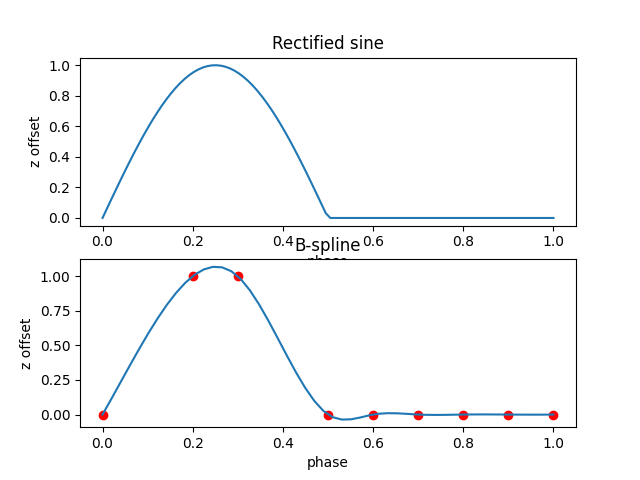

In [11]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

def rectified_sin_trajectory(phase):
    t = phase * 2 * np.pi
    return np.maximum(0, np.sin(t))

phase = np.linspace(0, 1, 100)

rectified_sin_z = rectified_sin_trajectory(phase)
##############################
fig, axes = plt.subplots(2, 1)

ax = axes[0]
ax.set_xlabel('phase')
ax.set_ylabel('z offset')
ax.set_title('Rectified sine')

ax.plot(phase, rectified_sin_z)
##############################

num_items = 9
spline_x = np.array([0, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])[0:num_items]
spline_z = np.array([0, 1, 1, 0, 0, 0, 0, 0, 0])[0:num_items]
bspline_trajectory = make_interp_spline(spline_x, spline_z)

##############################
ax = axes[1]
ax.set_xlabel('phase')
ax.set_ylabel('z offset')
ax.set_title('B-spline')

phase_new = np.linspace(0, spline_x[-1], 50)
ax.plot(phase_new, bspline_trajectory(phase_new))
ax.scatter(spline_x, spline_z, c='r')
plt.show()

For the sake of completeness, this is how bezier curve will look like. As you can see, it doesn't follow control points, and thus is not the best choice for our use case.

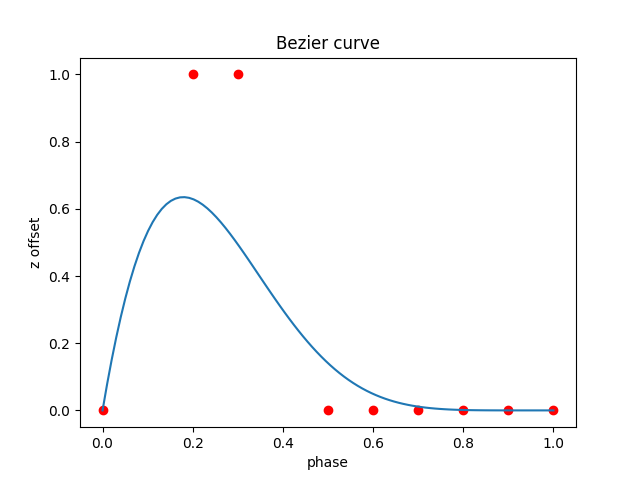

In [12]:
from scipy.special import comb

def bezier_curve(control_points:np.ndarray, t):
    """
    Compute a point on a Bézier curve using the Bernstein polynomial form.

    :param control_points: List of control points [(x0, y0), (x1, y1), ...]
    :param t: Parameter in range [0,1]
    :return: (x, y) coordinate of the curve at parameter t
    """
    n = len(control_points) - 1
    result = np.zeros(control_points.shape[1])

    for i, p in enumerate(control_points):
        bernstein = comb(n, i) * (t**i) * ((1 - t) ** (n - i))
        result += bernstein * p

    return result


fig, ax = plt.subplots(1, 1)

ax.set_xlabel('phase')
ax.set_ylabel('z offset')
ax.set_title('Bezier curve')

xnew = np.linspace(0, 1, 10)
points = np.array([spline_x, spline_z]).T
ax.plot(phase, [bezier_curve(points, t)[1] for t in phase])
ax.scatter(points[:, 0], points[:, 1], c='r')
plt.show()

### Defining gaits as b-spline control points

Having BSplines as interpolation mechanism it is easy to define gaits as a sequence of control points.

As we already know every gait has two phases: swing and stance. The first parameter for those phases is the duration.

Each phase has its own additional parameters:
 1. swing phase:
    - lift height
    - step length
    - swing speed
 2. stance phase:
    - step length
    - stance speed

To keep things simple for the first iteration we are going to keep speed constant and equal between phases.

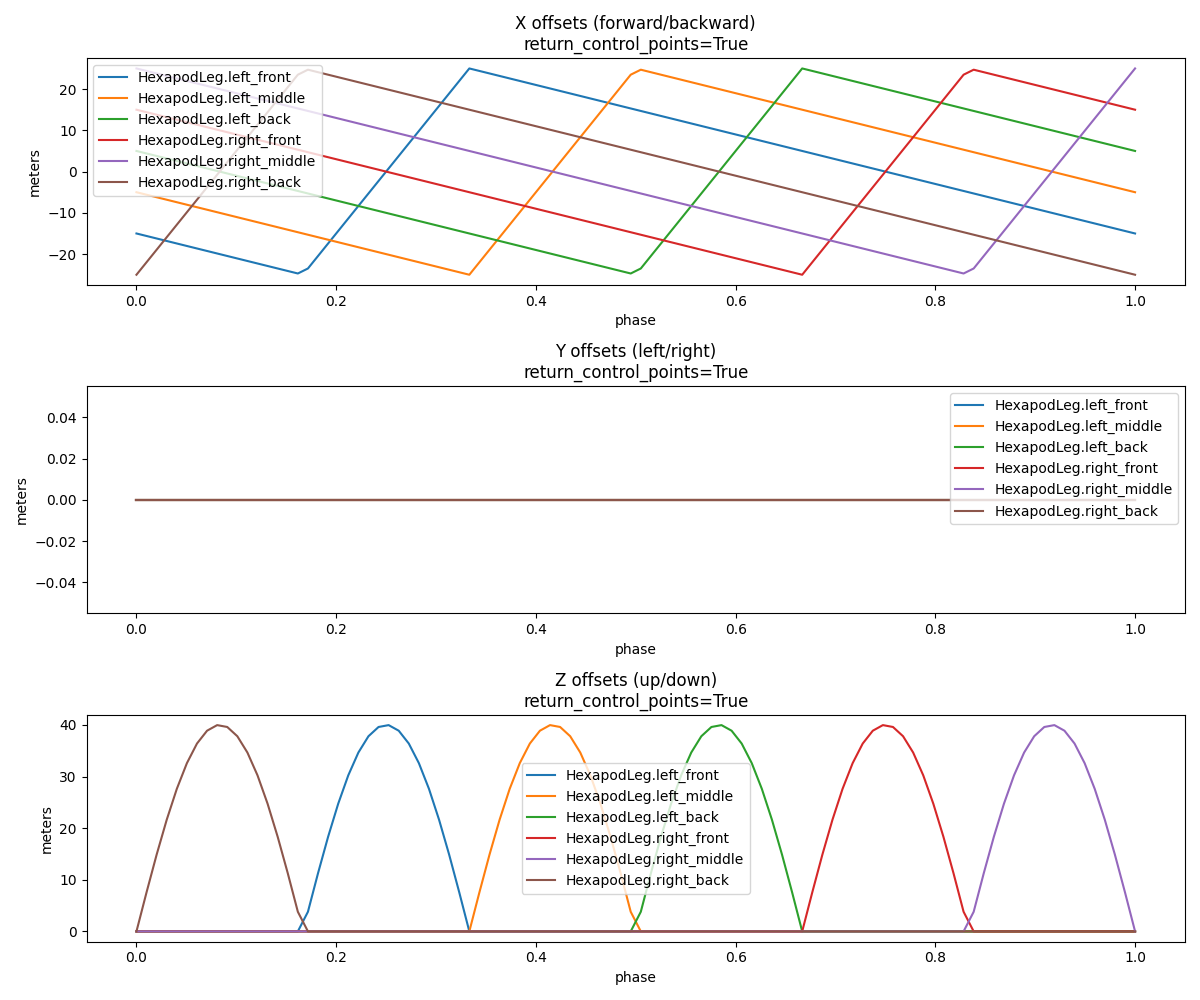

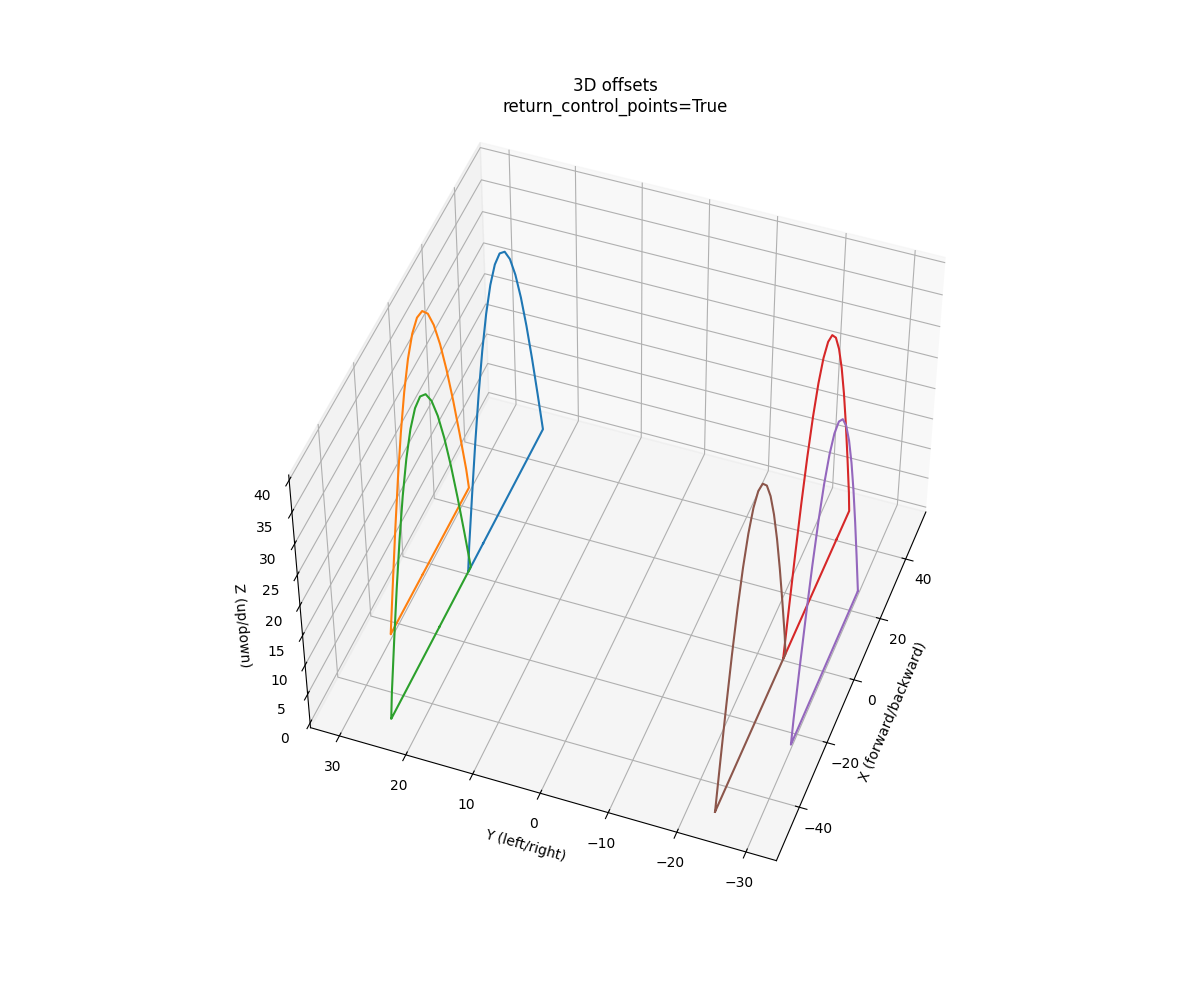

In [ ]:
from abc import abstractmethod
import enum

from models import HexapodLeg
from scipy.interpolate import make_interp_spline


class Gait(enum.Enum):
    ripple = enum.auto()
    wave = enum.auto()
    tripod = enum.auto()


class GaitParameters:
    def __init__(self, step_length=50, step_height=40):
        self.step_length = step_length
        self.step_height = step_height

    @property
    @abstractmethod
    def lift_duration(self):
        pass

    @property
    def phase_offset_for_leg(self, leg):
        pass


class ParametricGaitGenerator(GaitGenerator):
    def __init__(
        self,
        gait=Gait.wave,
        step_length=50,  # Length of each step in meters
        step_height=40,  # Height of leg lift in meters
    ):
        """
        Initialize the ParametricGaitGenerator.

        Parameters:
        -----------
            step_length: Length of each step in meters
            step_height: Height of leg lift in meters
        """
        # Store parameters as member fields
        self.step_length = step_length
        self.step_height = step_height

        self.full_phase = 1.0
        self.__gait = gait

        # Leg phase is split into lift and push phases.
        # 0..lift_duration - lift phase
        # lift_duration..1.0 - push phase
        if self.__gait == Gait.wave:
            __leg_sequence = [
                HexapodLeg.right_back,
                HexapodLeg.right_middle,
                HexapodLeg.right_front,
                HexapodLeg.left_back,
                HexapodLeg.left_middle,
                HexapodLeg.left_front,
            ]

            leg_count = len(__leg_sequence)
            self.lift_duration = self.full_phase / leg_count

            self.leg_phase_offset = {
                leg: self.lift_duration * i for i, leg in enumerate(__leg_sequence)
            }

            self.last_offset = {leg: np.array([0, 0, 0]) for leg in __leg_sequence}
            self.last_phase = {leg: 0 for leg in __leg_sequence}
        else:
            raise NotImplementedError()

        super().__init__()

    def get_offsets_at_phase(
        self, phase, gait=Gait.wave, return_control_points=False
    ) -> dict[str, Point3D]:
        return {
            leg: self.get_offsets_at_phase_for_leg(leg, phase, gait, return_control_points)
            for leg in self.leg_phase_offset
        }

    def get_offsets_at_phase_for_leg(
        self, leg, phase, gait=Gait.wave, return_control_points=True
    ) -> Point3D:
        leg_phase = self.leg_phase_offset[leg] + phase
        # leg_phase = phase # ignore leg offset for now, all legs lift at the same time
        leg_phase %= self.full_phase

        next_control_point = self.get_control_points_at_phase(leg_phase)
        if return_control_points:
            return Point3D(next_control_point)

        last_phase = self.last_phase[leg]
        since_last_phase = leg_phase - self.last_phase[leg]
        self.last_phase[leg] = leg_phase

        spline_phase_step = 0.1
        spline = np.array(
            [
                self.last_offset[leg],
                next_control_point,
                # self.get_control_points_at_phase(leg_phase + spline_phase_step),
                # self.get_control_points_at_phase(leg_phase + spline_phase_step * 2),
                # self.get_control_points_at_phase(leg_phase + spline_phase_step * 3),
                # self.get_control_points_at_phase(leg_phase + spline_phase_step * 4),
            ]
        )
        if leg_phase < self.lift_duration:
            # Swing phase - leg in air moving forward
            spline_phase = np.interp(leg_phase, [0, self.lift_duration], [0, 1])
        else:
            # Stance phase - leg on ground moving backward
            spline_phase = np.interp(leg_phase, [self.lift_duration, 1], [0, 1])

        result = bezier_curve(spline, spline_phase)
        result[0] = next_control_point[0]

        # spline_x, spline_y, spline_z = self.__bspline(spline)
        # spline_phase = np.interp(leg_phase, [last_phase, last_phase + since_last_phase + spline_phase_step * 4], [0, 1])
        # result = [spline_x(spline_phase), spline_y(spline_phase), spline_z(spline_phase)]
        self.last_offset[leg] = result

        return Point3D(result)

    def get_control_points_at_phase(self, leg_phase) -> np.ndarray:
        half_step = self.step_length / 2
        if leg_phase < self.lift_duration:
            # Swing phase - leg in air moving forward
            t = np.interp(leg_phase, [0, self.lift_duration], [0, 1])
            x_control_point = np.interp(leg_phase, [0, self.lift_duration], [-half_step, half_step])
            z_control_point = np.sin(t * np.pi) * self.step_height
        else:
            # Stance phase - leg on ground moving backward
            x_control_point = np.interp(leg_phase, [self.lift_duration, 1], [half_step, -half_step])
            z_control_point = 0  # On ground

        return np.array(
            [
                x_control_point,
                0,
                z_control_point,
            ]
        )

    @staticmethod
    def __bspline(control_points: np.ndarray):
        """
        Compute a smooth B-spline interpolation of control points using make_interp_spline.

        :param control_points: List of control points [[x0, y0], [x1, y1], ...]
        :return: Interpolated curve points
        """
        t = np.linspace(0, 1, len(control_points))

        control_x, control_y, control_z = zip(*control_points)
        spline_x = make_interp_spline(t, control_x)
        spline_y = make_interp_spline(t, control_y)
        spline_z = make_interp_spline(t, control_z)

        return spline_x, spline_y, spline_z


gait_gen = ParametricGaitGenerator()
gait_gen.visualize_continuous(steps=100, return_control_points=True)
_ = gait_gen.visualize_continuous_in_3d(steps=100, return_control_points=True)


# gait_gen.visualize_continuous(steps=100, return_control_points=False)
# _ = gait_gen.visualize_continuous_in_3d(steps=100, return_control_points=False)


interactive(children=(IntSlider(value=0, description='frame', max=60), IntSlider(value=0, description='directi…

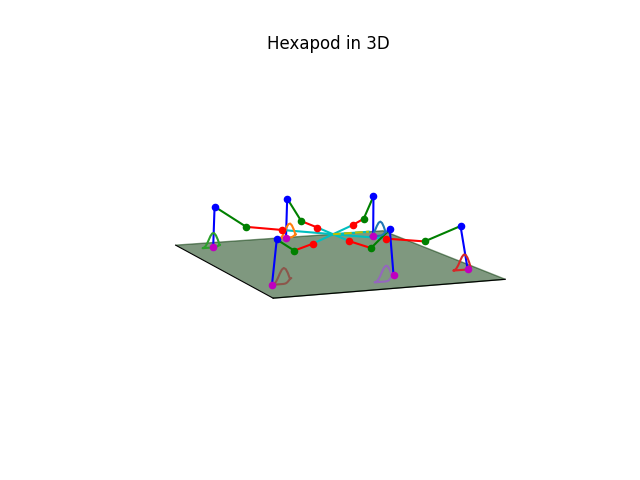

In [31]:
hexapod = HexapodModel()
hexapod.forward_kinematics(0, -25, 110)

directional_param_gait_gen = DirectionalGaitGenerator(gait_gen)
anim = animate_hexapod_gait_with_direction(
    hexapod,
    directional_param_gait_gen,
    interactive=False,
    skip=True, ######
    animate_trajectory=True,
    animate_direction_degrees=False,
    repeat=1,
)
inter = animate_hexapod_gait_with_direction(
    hexapod, directional_param_gait_gen, interactive=True, skip=False
)
